# Point Mass Car with MPC Path Planner

The object of this notebook is to develop a simple path planner for a "point mass car" using Model Predictive Control. This is a common practice in autonomous ground vehicles, because the model predictive controller uses a very simplistic model of the vehicle (a point mass) to determine a feasible path within some acceleration bounds around some obstacle, and then a low-level controller on the vehicle follows that path.


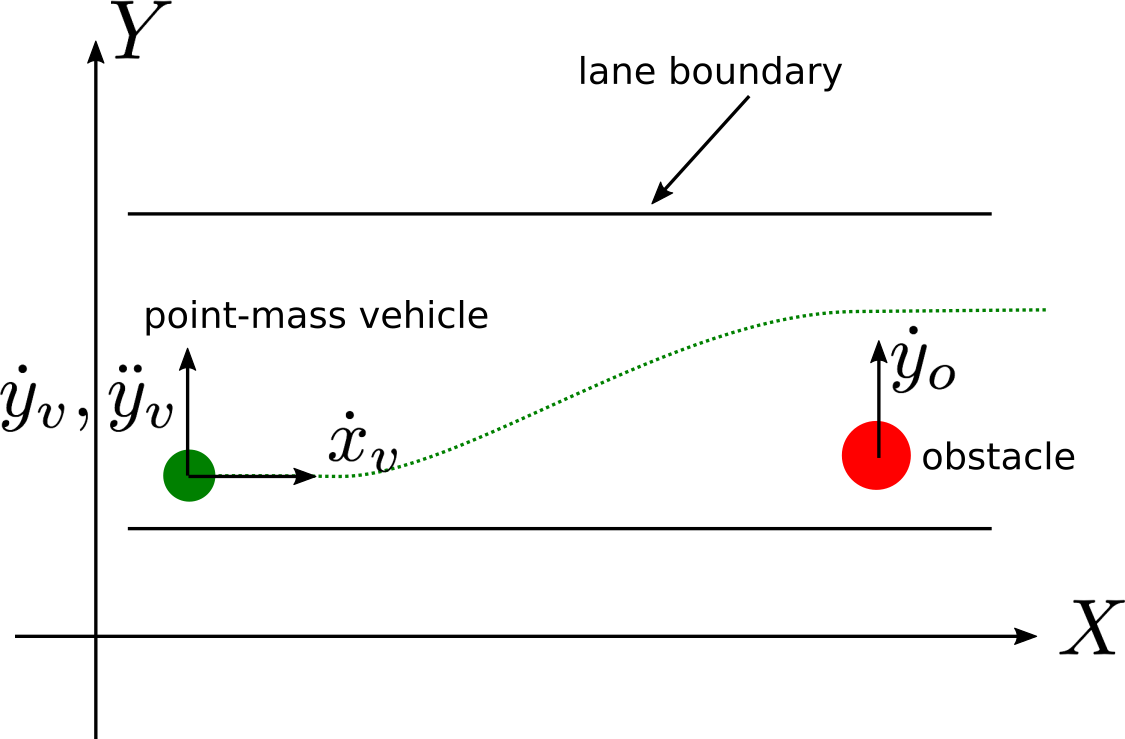

In [7]:
from IPython.display import Image
Image('../pointmass_mpc.png')

## Assumptions of the model

We will proceed assuming that the vehicle *only* swerves, and the obstacle we see *only moves in the y-direction with constant velocity*. We will use an Euler approximation for numerical integration of the equations of motion.

## Model predictive control setup

Model predictive control is actually a fairly simple paradigm. The vehicle predicts its own behavior and the behavior of the obstacle $N_p$ timesteps $t_p$ into the future for some initial guess of its inputs at each timestep on the prediction horizon from $t\rightarrow+N_pt_p$, and then computes the value of some objective function $J(\vec{x}_v,\vec{x_o},\vec{u})$ for that input vector $\vec{u}$. Then, it uses an optimizer to compute the optimal input trajectory $\vec{u}^\star$, and its input at time $t$ is $\vec{u}^\star(0)$. At the next timestep, the process is repeated, creating implicit feedback to complement the explicit feedforward of the optimization procedure.

This is provably stable for certain conditions, and is fairly widely accepted in practice. For our case, our objective function will be a weighted sum of distance from lane center, input penalty (penalizing lateral acceleration), and distance from the predicted position of the obstacle.

$$ J = \sum_{k=1}^{N_p} K_1(k){u_v^2(k)} + K_2(k) y_v^2(k) + + K_3(k) \dot{y}_v^2(k)+K_4(k) \frac{1}{(y_v(k)-y_o(k)+\delta)^2}$$

Notice that the $x$ position of the vehicle is not in the optimizer. This is on purpose. We will also want to constrain the y-acceleration allowed in the optimization, because we want to make sure the path is feasible for a vehicle to follow. We will subject the optimization to the constraint that $|u|<=u_{max}$, which we'll set in the linear tire region for a vehicle (for now). We can do this using the "bounds" parameter in scipy.minimize, which is the function we'll use for the optimization. 

Something else that's important to note is that $\vec{K}_4$, or the weight on the distance from the vehicle to the obstacle, is something we'll vary as the vehicle gets closer to the obstacle. The time-to-collision can be defined as:

$$ T_c = \frac{x_o-x_v}{\dot{x}_v}$$

At each instant, the MPC algorithm calculates $T_c$ and then adjusts $\vec{K}_4$ so that $\vec{K}_4(k_c)=K_4$ and $0$ at every other prediction timestep. Here, $k_c=int(\frac{T_c}{dT_p})$, where $dT_p$ is the MPC controller's prediction timestep. In plain english, this means that the optimizer only cares about the distance from the obstacle *at the instant it passes the obstacle*. 

In [8]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
import IPython.display as IPdisplay
import glob
from PIL import Image as PIL_Image
from images2gif2 import writeGif
import os

class PointMassVehicle:
    def __init__(self,x=0,y=0,xdot=10,ydot=0,dT=0.01,umax = 5):
        self.x = x#initial x position of vehicle
        self.y = y#initial y position of vehicle
        self.xdot = xdot#vehicle forward velocity
        self.ydot = ydot
        self.umax = umax#maximum lateral acceleration
        self.dT = dT
    def updateStates(self,u):
        self.ydot = self.ydot+u*self.dT #euler update of vehicle velocity (constant acceleration)
        self.x = self.x+self.xdot*self.dT#euler update of vehicle position (constant velocity)
        self.y = self.y+self.ydot*self.dT
        #clamp acceleration at the maximum
        if abs(u)>self.umax:
            u = self.umax*sign(u)
        #update y velocity for next timestep

        return array([self.x,self.xdot,self.y,self.ydot])
    
    
class PointMassDeer:
    def __init__(self,x=0,y=0,xdot=0,ydot=0,dT=0.01,umax = 5):
        self.x = x#initial x position of vehicle
        self.y = y#initial y position of vehicle
        self.xdot = xdot#vehicle forward velocity
        self.ydot = ydot
        self.umax = umax#maximum lateral acceleration
        self.dT = dT
    def updateStates(self,u):
        self.ydot = self.ydot+u*self.dT #euler update of vehicle velocity (constant acceleration)
        self.x = self.x+self.xdot*self.dT#euler update of vehicle position (constant velocity)
        self.y = self.y+self.ydot*self.dT
        #clamp acceleration at the maximum
        if abs(u)>self.umax:
            u = self.umax*sign(u)
        #update y velocity for next timestep

        return array([self.x,self.xdot,self.y,self.ydot])

class MPC_Vehicle:
    def __init__(self,K1,K2,K3,K4,umax,dtP,Np):
        self.K1,self.K2,self.K3,self.K4,self.umax,self.dtP,self.Np = K1,K2,K3,K4,umax,dtP,Np
        


In [9]:
def ObjectiveFn(uvec,yobstacle,xvehicle,pmvehicle,K1,K2,K3,K4):
        delta = 0.1
        #first reset the predictive model's states to where we are currently. 
        pmvehicle.x,pmvehicle.xdot,pmvehicle.y,pmvehicle.ydot = xvehicle[0],xvehicle[1],xvehicle[2],xvehicle[3]
        J = 0 #initialize the objective to zero
        #now loop through and update J for every timestep in the prediction horizon.
        for ind in range(0,len(uvec)): #compute for each step in the prediction horizon
            #print ind
            xv = pmvehicle.updateStates(uvec[ind])
            J = J + K1[ind]*uvec[ind]**2 + K2[ind] *(xv[2])**2 + K3[ind]*xv[3]**2+K4[ind] * 1/(xv[2]-yobstacle[ind]+delta)**2
        return J

def ObjectiveFn_obs(uvec,yvehicle,xdeer,pmdeer,goalpos_obs,K1,K2,K3,K4):
        delta = 0.1
        #first reset the predictive model's states to where we are currently. 
        pmdeer.x,pmdeer.xdot,pmdeer.y,pmdeer.ydot = xdeer[0],xdeer[1],xdeer[2],xdeer[3]
        J = 0 #initialize the objective to zero
        #now loop through and update J for every timestep in the prediction horizon.
        for ind in range(0,len(uvec)): #compute for each step in the prediction horizon
            #print ind
            x = pmdeer.updateStates(uvec[ind])
            J = J + K1[ind]*uvec[ind]**2 + K2[ind] *(goalpos_obs-x[2])**2 + K3[ind]*x[3]**2+K4[ind] * 1/(x[2]-yvehicle[ind]+delta)**2
            #J = J + K2[ind] *(goalpos_obs-x[2])**2
        return J
    
#now create a function that the MPC algorithm uses to predict the obstacle's position
def MPC_predictobstaclepos(yo_now,vo_now,nsteps,dt):
    yobs_now = zeros(nsteps)
    yobs_now[0] = yo_now
    for ind in range(1,nsteps):
        yobs_now[ind] = yobs_now[ind-1]+dt*vo_now
    return yobs_now

In [38]:
def animate_collision(gif_filename,t,skips,xvehicle_store,x_obstacle,y_obstacle):
    figure(figsize=(15,5))
    n=0
    for ind in range(0,len(t)):
        cla()
        plot(xvehicle_store[0:ind,0],xvehicle_store[0:ind,2],'k',x_obstacle[ind],y_obstacle[ind],'rs',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
        
        ylim([-1.1*W,1.1*W])
        xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
        xlabel('X position (m)')
        ylabel('Y position(m)')
        legend(['vehicle path','obstacle','lane boundaries'])
        plot(xvehicle_store[ind,0],xvehicle_store[ind,2],'ko')
        savefig('snaps/' + gif_filename + '/img' + str(n).zfill(3) + '.png',
                    bbox_inches='tight')
        n+=1


    close()
    path = 'snaps/' + gif_filename + '/*.png'
    #print path
    images = [PIL_Image.open(image) for image in glob.glob(path)]
    #print images
    file_path_name = gif_filename + '.gif'
    #print file_path_name
    writeGif(file_path_name, images, duration=.1)

0.784818753791 -0.784818753791


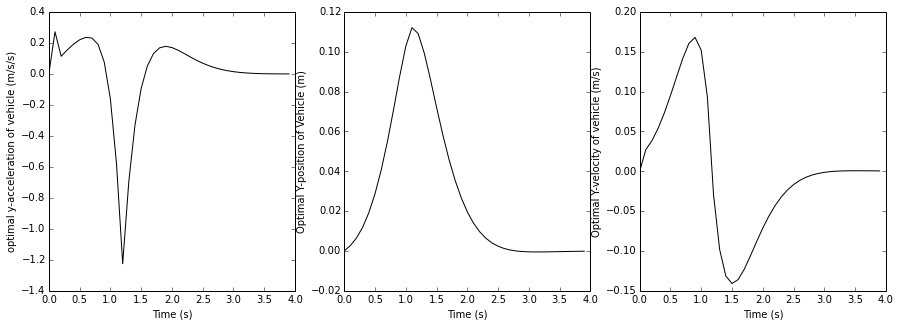

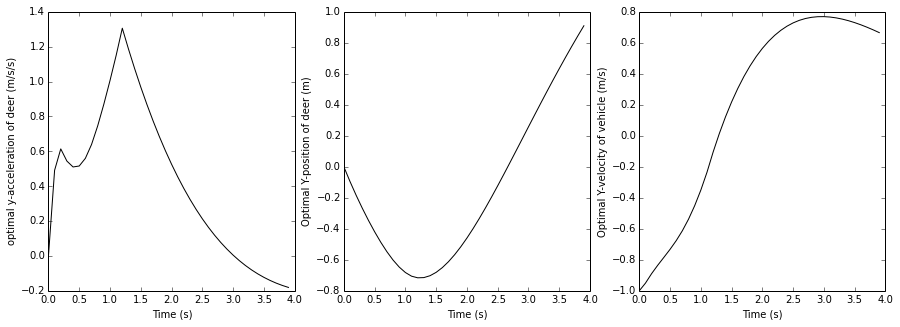

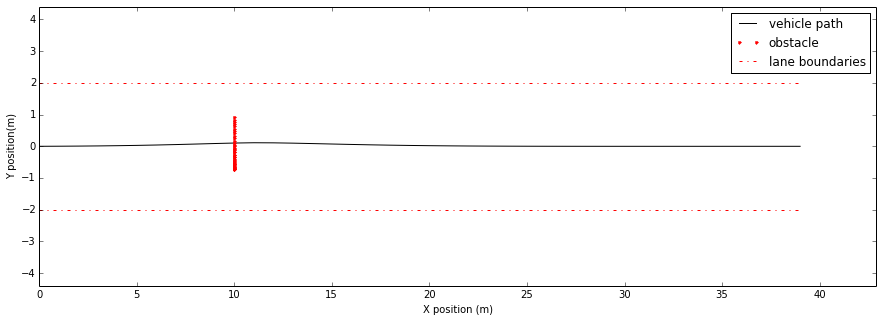

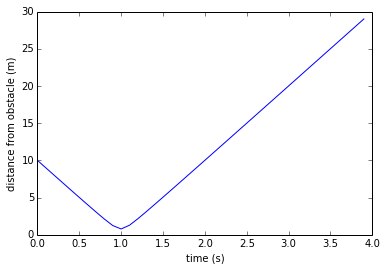

In [57]:

def runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,yobs,ydotobs,K1mag_obs,K2mag_obs,K3mag_obs,K4mag_obs,uvmax_obs,goalpos_obs,plot_results=True):
    xv0 = 0#initial x-position of vehicle
    yv0=0 #initial y position of vehicle
    ydotv0 = 0# initial y velocity of vehicle
    u0 = 0#initial value of vehicle y-acceleration

    #optimizer variables for the car
    K1 = K1mag*ones(Np)#weight on input
    K2 = K2mag*ones(Np)#weight on y vehicle
    #K3 = zeros(Np);K3[-1] = 1000#weight on terminal y-velocity. Only Penalize TERMINAL!!
    K3 = K3mag*ones(Np)#constant velocity penalty
    K4 = zeros(Np)#weight on distance from obstacle.
    delta = 0.1 # term added to inverse to avoid division by zero
    
    #optimizer variables for the deer
    K1_obs = K1mag_obs*ones(Np)#weight on input
    K2_obs = K2mag_obs*ones(Np)#weight on y vehicle
    #K3 = zeros(Np);K3[-1] = 1000#weight on terminal y-velocity. Only Penalize TERMINAL!!
    K3_obs = K3mag_obs*ones(Np)#constant velocity penalty
    K4_obs = zeros(Np)#weight on distance from obstacle.
     


    #set up things that will stay the same over time
    u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
    #vehicle's model of itself
    vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
    #deer's model of itself
    deerpredict = PointMassDeer(xobs,yobs,0,ydotobs,dt,uvmax_obs)
    #initial vehicle states
    xvehicle = array([xv0,xdotv,yv0,ydotv0])
    #initial deer states
    xdeer = array([xobs,0,yobs,ydotobs])
    #set up constraint on the optimization
    #set up the bounds on umax. This needs to be a list of tuples (min,max)
    bounds = [(-uvmax,uvmax)]
    bounds_deer = [(-uvmax_obs,uvmax_obs)]
    for ind in range(1,len(u0)):
        bounds.insert(0,(-uvmax,uvmax))
        bounds_deer.insert(0,(-uvmax_obs,uvmax_obs))


    #set up time and time-dependent variables
    vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
    xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
    u_store = array([0])#store the first value of each optimal input 
    t = arange(0,simtime,dt)#time vector

    deersimulate = PointMassDeer(xobs,yobs,0,ydotobs,dt,uvmax_obs)
    xdeer_store = array([xobs,0,yobs,ydotobs])
    udeer_store = array([0])#store the first value of each optimal input

    pass_error = 0
    
    for ind in range(1,len(t)):
        ##### WE must find the index in the vector of weights where we'll cross the obstacle

        #find the distnce from the obstacle
        obstacle_distance  = deersimulate.x- vehiclesimulate.x#calculate the current distance from the obstacle
        if obstacle_distance>=0:
            #find the time to collision, assuming obstacle only moves in y-direction
            ttc = obstacle_distance/vehiclesimulate.xdot
            #now look at the vector of preview times for the prediction horizon
            preview_times = arange(0,Np*dtP,dtP)
            #now figure out which index in this vector most closely represents our collision time
            collision_index = argmin(abs(preview_times-ttc))
            #now set K4 (for both vehicle and obstacle)
            K4 = zeros(Np)
            K4[collision_index] = K4mag
            
            K4_obs = zeros(Np)
            K4_obs[collision_index] = K4mag_obs
            
            if collision_index==0:
                pass_error = deersimulate.y-vehiclesimulate.y
        else:
            K4 = zeros(Np)
            K4_obs = zeros(Np)

        #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
        yhatobs_now = MPC_predictobstaclepos(deersimulate.y,deersimulate.ydot,Np,dtP)#predict obstacle position
        #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
        umpc_vehicle = minimize(ObjectiveFn,u0,args=(yhatobs_now,xvehicle,vehiclepredict,K1,K2,K3,K4),bounds=bounds,method='SLSQP',options={'disp': False})
        opt_u_vehicle = umpc_vehicle.x#pull out the optimal input
        
        #use MPC to figure out what deer does
        yhatvehicle_now = MPC_predictobstaclepos(vehiclesimulate.y,vehiclesimulate.ydot,Np,dtP)
        umpc_obs = minimize(ObjectiveFn_obs,u0,args=(yhatvehicle_now,xdeer,deerpredict,goalpos_obs,K1_obs,K2_obs,K3_obs,K4_obs),bounds=bounds_deer,method='SLSQP',options={'disp': False})
        opt_u_obs = umpc_obs.x#pull out the optimal input
        
        #update vector of states for vehicle
        xvehicle = vehiclesimulate.updateStates(opt_u_vehicle[0])
        xvehicle_store = vstack((xvehicle_store,xvehicle))
        u_store = append(u_store,opt_u_vehicle[0])
        
        #update vector of states for deer
        xdeer = deersimulate.updateStates(opt_u_obs[0])
        xdeer_store = vstack((xdeer_store,xdeer))
        udeer_store = append(udeer_store,opt_u_obs[0])

    distance = sqrt((xvehicle_store[:,2]-xdeer_store[:,2])**2+(xvehicle_store[:,0]-xdeer_store[:,0])**2)
    miss_margin = min(distance)
    
    if plot_results==True:
        #now plot the input vector U and the vehicle y-position and y-velocity
        figure(figsize=(15,5))
        subplot(1,3,1)
        plot(t,u_store,'k')
        xlabel('Time (s)')
        ylabel('optimal y-acceleration of vehicle (m/s/s)')
        subplot(1,3,2)
        plot(t,xvehicle_store[:,2],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-position of Vehicle (m)')
        subplot(1,3,3)
        plot(t,xvehicle_store[:,3],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-velocity of vehicle (m/s)')
        
        figure(figsize=(15,5))
        subplot(1,3,1)
        plot(t,udeer_store,'k')
        xlabel('Time (s)')
        ylabel('optimal y-acceleration of deer (m/s/s)')
        subplot(1,3,2)
        plot(t,xdeer_store[:,2],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-position of deer (m)')
        subplot(1,3,3)
        plot(t,xdeer_store[:,3],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-velocity of vehicle (m/s)')

        figure(figsize=(15,5))
        plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xdeer_store[:,0],xdeer_store[:,2],'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
        ylim([-1.1*W,1.1*W])
        xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
        xlabel('X position (m)')
        ylabel('Y position(m)')
        legend(['vehicle path','obstacle','lane boundaries'])
        
        figure()
        plot(t,distance)
        xlabel('time (s)')
        ylabel('distance from obstacle (m)')
    
    
    
    return miss_margin,pass_error,xvehicle_store,u_store,xdeer_store,udeer_store

#simulation variables
dtP = 0.1
Np = 10

dt = 0.1
simtime = 4 #second
#gravitational constant
g = 9.81 #m/s/s

#vehicle parameters
uvmax = 0.6*g #the maximum lateral acceleration for the vehicle.
xdotv = 10 #m/s



#environment variables
ylane_right = -2 #meters
ylane_left = 2 #meters, left lane boundary
W = ylane_left-ylane_right

K1mag = 0.1
K2mag = 10
K3mag = 1
K4mag = 10

K1mag_obs = 1#.1
K2mag_obs = 1
K3mag_obs = 1#1
K4mag_obs = 10
goalpos_obs = ylane_left
uvmax_obs = 6#

xobs = 10
yobs = 0
ydotobs = -W/4



miss_margin,pass_error,junk1,junk2,junk3,junk4=runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,yobs,ydotobs,K1mag_obs,K2mag_obs,K3mag_obs,K4mag_obs,uvmax_obs,goalpos_obs,plot_results=True)
print miss_margin,pass_error

In [ ]:
t = arange(0,simtime,dt)#time vector
print len(t)
gif_filename = 'courteous_deer4'
os.system('rm '+gif_filename+'.gif')
os.system('rm -rf snaps/'+gif_filename)
os.system('mkdir snaps/'+gif_filename)
#miss_margin,pass_error,xvehicle_store,u_store,x_obstacle,y_obstacle =runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,possible_yobs[minimum_margin_case[0]],possible_ydotobs[minimum_margin_case[1]],True)
miss_margin,pass_error,xvehicle_store,u_store,xdeer,udeer_store=runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,yobs,ydotobs,K1mag_obs,K2mag_obs,K3mag_obs,K4mag_obs,uvmax_obs,goalpos_obs,plot_results=False)
animate_collision(gif_filename,t,1,xvehicle_store,xdeer[:,0],xdeer[:,2])
IPdisplay.Image(url=gif_filename+'.gif') 